In [109]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

import numpy as np

In [110]:
def build_lenet5():
     ##LeNet requires to have input 32x32 based on its architecture
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1))) # first layer of network, that contains 6 filters with 5x5 with activation function ReLU - which introduces non-linearity to the model helping it to learn more complex patterns in the data
    model.add(layers.AveragePooling2D(pool_size=(2,2))) # pooling layer to reduce the dimension - it should make the position of object in the picture less relevant
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Flatten()) # transforms 2D matrix into 1D vector to connect convolutional layers with dense layers
    model.add(layers.Dense(120, activation='relu')) # 120 neurons 
    model.add(layers.Dense(84, activation='relu')) # 84 neurons
    model.add(layers.Dense(10, activation='softmax')) # softmax outputs the probabilities for each class
    return model

In [111]:
lenet5_model = build_lenet5()
lenet5_model.summary()

/home/luky/playground/handwriting_recognition/lenet5/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)


(60000, 28, 28)


In [113]:

train_images = tf.pad(train_images, [[0, 0], [2, 2], [2, 2]])
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.pad(test_images, [[0, 0], [2, 2], [2, 2]])
test_images = tf.cast(test_images, tf.float32) / 255.0

train_images = 1.0 - train_images # to revert colors to train the network 
additional_train_images = train_images[0:30000]
additional_train_labels = train_labels[0:30000]
print(additional_train_images.shape)
print(additional_train_labels.shape)
train_images_numpy = train_images.numpy()


(30000, 32, 32)
(30000,)


In [114]:

def rotate_images(train_images_numpy) -> np.ndarray:
    for i in range(len(train_images_numpy)):
        if i % 9 ==0:
            k = np.random.choice([1, 3])
            train_images_numpy[i] = np.rot90(train_images_numpy[i], k=k)
    return tf.convert_to_tensor(train_images_numpy)


In [115]:
#it does not work perfectly
# def move_image(train_images_numpy) -> np.ndarray:
#     for m in range(len(train_images_numpy)):
#         if m % 3 ==0:
#             no_of_columns_to_be_moved = 0
#             no_size = 0
#             for k in range(len(train_images_numpy[m])):
#                 if min(train_images_numpy[m,:,k]) != 1:
#                     no_size+=1
#                 if no_size !=0:
#                     break
#             for i in range(len(train_images_numpy[m])):
#                 if min(train_images_numpy[m,:,i]) == 1: #no part of number is in this column
#                     no_of_columns_to_be_moved+=1
#                 else:
#                     train_images_numpy[m,:,i-no_of_columns_to_be_moved] = train_images_numpy[m,:,i]
#             for j in range(no_of_columns_to_be_moved+no_size+1,len(train_images_numpy[m])):
#                 train_images_numpy[m,:,j] = 1
#     return tf.convert_to_tensor(train_images_numpy) 
def move_image(train_images_numpy) -> np.ndarray:
    for m in range(len(train_images_numpy)):
        if m % 3 == 0:
            image = train_images_numpy[m]

            # Identify the bounding box of the digit
            min_col = 0
            max_col = image.shape[1]
            
            for k in range(image.shape[1]):
                if np.min(image[:, k]) != 1:
                    min_col = k
                    break
            
            for k in range(image.shape[1] - 1, -1, -1):
                if np.min(image[:, k]) != 1:
                    max_col = k
                    break
            
            # Calculate the width of the digit
            digit_width = max_col - min_col + 1
            
            # Create a new image and move the digit part
            new_image = np.ones_like(image)
            new_image[:, :digit_width] = image[:, min_col:max_col + 1]
            
            # Replace the old image with the new one
            train_images_numpy[m] = new_image

    return tf.convert_to_tensor(train_images_numpy)

In [116]:
def add_noise_to_background(images_numpy, noise_level=0.1) -> np.ndarray:
    noise = np.random.normal(loc=0.0, scale=noise_level, size=images_numpy.shape)
    noisy_images = images_numpy + noise
    # Ensure the pixel values are still in the range [0, 1]
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

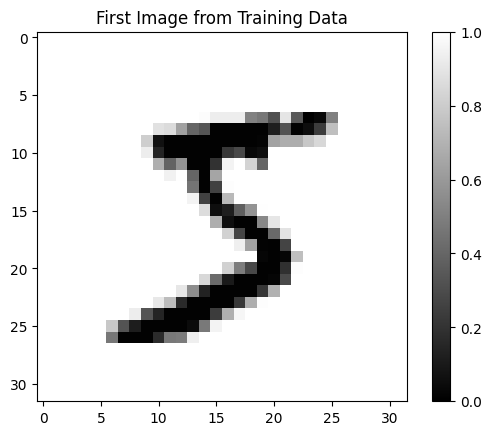

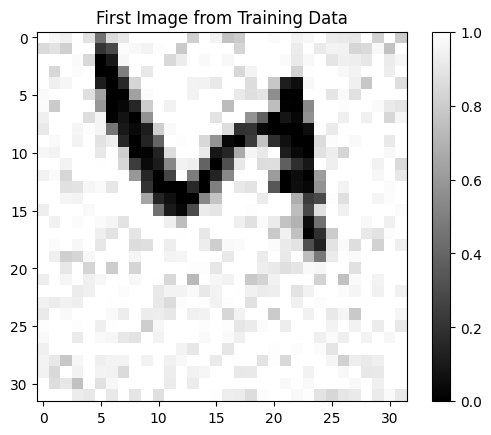

In [117]:
plt.imshow(train_images[0, :, :], cmap='gray')  # 'cmap' specifies that we want to see the image in grayscale
plt.title('First Image from Training Data')
plt.colorbar()
plt.show()

train_images_numpy = train_images.numpy()
train_images = move_image(train_images_numpy)
train_images_numpy = train_images.numpy()
#train_images = rotate_images(train_images_numpy)

train_images_rotated = rotate_images(train_images_numpy)
train_images_noisy = add_noise_to_background(train_images_rotated.numpy())

plt.imshow(train_images_noisy[0, :, :], cmap='gray')  # 'cmap' specifies that we want to see the image in grayscale
plt.title('First Image from Training Data')
plt.colorbar()
plt.show()

In [118]:
# Combine the original and additional training images
train_images_combined = np.concatenate((train_images_noisy, additional_train_images), axis=0)
train_labels_combined = np.concatenate((train_labels, additional_train_labels), axis=0)

train_images_tensor = tf.convert_to_tensor(train_images_combined)
train_labels_tensor = tf.convert_to_tensor(train_labels_combined)
print(train_images_tensor.shape)

(90000, 32, 32)


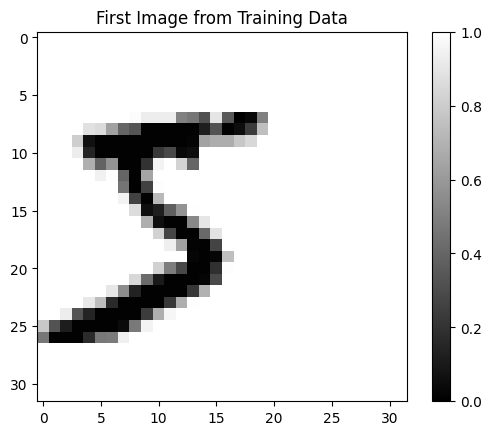

In [119]:
plt.imshow(train_images[0, :, :], cmap='gray')  # 'cmap' specifies that we want to see the image in grayscale
plt.title('First Image from Training Data')
plt.colorbar()
plt.show()

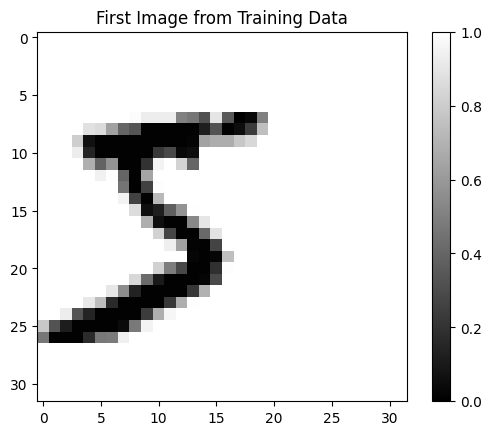

In [120]:

# Plotting the image
plt.imshow(train_images[0, :, :], cmap='gray')  # 'cmap' specifies that we want to see the image in grayscale
plt.title('First Image from Training Data')
plt.colorbar()
plt.show()


In [121]:


train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)


#create batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)  # Shuffle and batch the data
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)  # Only batch the test data (no need to shuffle)
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>


In [122]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.8)

In [123]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [124]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = lenet5_model(images,training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, lenet5_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lenet5_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [125]:
train_loss_results = []
train_accuracy_results = []
epochs = 5

for epoch in range(epochs):
    train_loss.reset_state()
    train_accuracy.reset_state()

    for images, labels in train_dataset:
        train_step(images, labels)
        
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_accuracy.result())        
    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100:.2f}%')

2024-06-24 17:45:19.874326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.5079385042190552, Accuracy: 85.10%


2024-06-24 17:46:03.591967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 1.2703967094421387, Accuracy: 52.81%


KeyboardInterrupt: 

In [ ]:
lenet5_model.save("lenet5_model.keras")

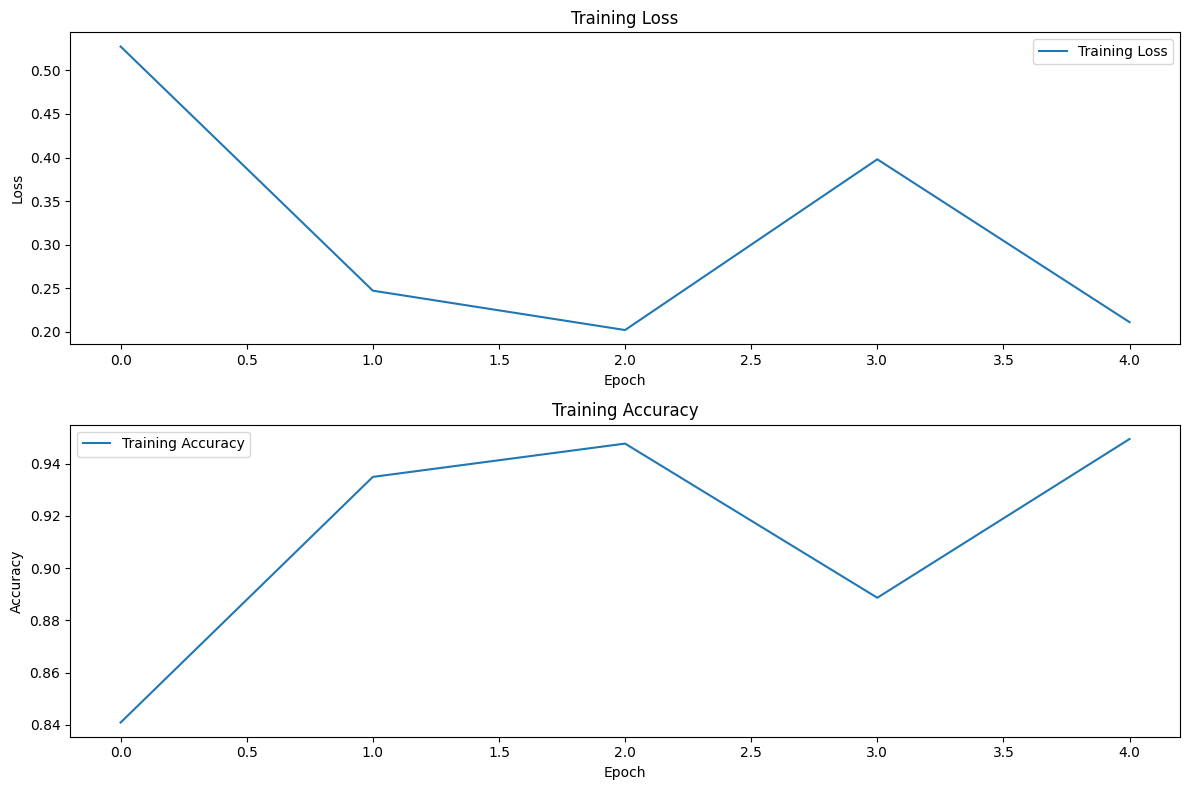

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(train_loss_results, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_results, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()